In [24]:
from cdlib import algorithms, viz
from networkx.algorithms import bipartite
from sklearn.metrics import f1_score
import networkx as nx
import pickle

# Helper Functions

In [21]:
def relabel_mappings(G):
    '''
    Given a graph with non-integer labeled nodes, relabel all its nodes to be integers.

    Return 3 objects:
    
    1) The new integer labeled graph
    2) A dictionary mapping the old ids to the new integer ids
    3) A dictionary mapping the new integer ids to the old ids
    '''
    old_id_to_int_id_dict = dict((id, int_id) for (id, int_id) in zip(G.nodes(), range(G.number_of_nodes())))

    new_G = nx.relabel_nodes(G, old_id_to_int_id_dict)
    int_id_to_old_id_dict = {int_id: old_id for old_id, int_id in old_id_to_int_id_dict.items()}

    return new_G, old_id_to_int_id_dict, int_id_to_old_id_dict

def get_node_to_communities_dict(coms):
    '''
    Return a dictionary mapping each node to a list of its community ids
    '''
    node_id_to_communities_dict = {}
    for community_id in range(len(coms)):
        for node in coms[community_id]:
            if node in node_id_to_communities_dict:
                node_id_to_communities_dict[node].append(community_id)
            else:
                node_id_to_communities_dict[node] = [community_id]
    
    return node_id_to_communities_dict

def select_cell_nodes_in_multiple_communities(orig_graph, node_id_to_communities_dict, int_id_to_old_id_dict):
    '''
    Given the node_id_to_communities_dict identify all the cell nodes that belong in more than one community

    The returned list of cell nodes are labeled using the original graph
    '''

    # Find the nodes that belong in more than one community  
    nodes_in_multiple_communities = []
    for node in node_id_to_communities_dict:
        if len(node_id_to_communities_dict[node]) > 1:
            nodes_in_multiple_communities.append(node)

    # Select only cell nodes and use the original graph labels
    cell_nodes_in_multiple_communities = []
    for node in nodes_in_multiple_communities:
        if orig_graph.nodes[int_id_to_old_id_dict[node]]['type'] == 'cell':
            cell_nodes_in_multiple_communities.append(int_id_to_old_id_dict[node])

    return cell_nodes_in_multiple_communities

def get_precision_recall_f1_score(gt_homographs, predicted_homographs):
    precision = len(gt_homographs & predicted_homographs) / len(predicted_homographs)
    recall = len(gt_homographs & predicted_homographs) / len(gt_homographs)
    f1_score = (2* precision * recall) / (precision + recall)

    return precision, recall, f1_score

# Synthetic Benchmark

In [22]:
SB_gt = pickle.load(open('ground_truth/synthetic_example_groundtruth_dict.pickle', 'rb'))
gt_homographs = set([val for val in SB_gt if SB_gt[val]=='homograph'])

## Bipartite

In [23]:
SB_graph_path = '../graph_construction/combined_graphs_output/synthetic_benchmark_bipartite/bipartite/bipartite.graph'
SB_graph = pickle.load(open(SB_graph_path, 'rb'))

SB_graph_new, old_id_to_int_id_dict, int_id_to_old_id_dict = relabel_mappings(G=SB_graph)

In [148]:
# coms = algorithms.big_clam(SB_graph_new)
# coms = algorithms.core_expansion(SB_graph_new)
# coms = algorithms.lpanni(SB_graph_new)
# coms = algorithms.danmf(SB_graph_new)

# coms_l = [algorithms.louvain(SB_graph_new), algorithms.label_propagation(SB_graph_new), algorithms.walktrap(SB_graph_new)]
# coms = algorithms.endntm(SB_graph_new, coms_l)

coms = algorithms.egonet_splitter(SB_graph_new)

print("There are:", len(coms.communities), "communities")

There are: 27 communities


In [149]:
node_id_to_communities_dict = get_node_to_communities_dict(coms.communities)
cell_nodes_in_multiple_communities = select_cell_nodes_in_multiple_communities(orig_graph=SB_graph, node_id_to_communities_dict=node_id_to_communities_dict, int_id_to_old_id_dict=int_id_to_old_id_dict)

if len(cell_nodes_in_multiple_communities) > 0:
    precision, recall, f1_score = get_precision_recall_f1_score(gt_homographs=gt_homographs, predicted_homographs=set(cell_nodes_in_multiple_communities))
    print("Nodes in multiple_communities:", cell_nodes_in_multiple_communities)
    print("Precision:", precision, "Recall:", recall, "F1-Score:", f1_score)
else:
    print("There are no cell nodes that belong in more than one community")

There are no cell nodes that belong in more than one community


### BiMLPA

In [64]:
# Convert the graph into a networkx bipartite graph
SB_graph_bipartite = nx.Graph()
cell_nodes = []
attr_nodes = []
for node in SB_graph:
    if SB_graph.nodes[node]['type'] == 'cell':
        cell_nodes.append(node)
    else:
        attr_nodes.append(node)
SB_graph_bipartite.add_nodes_from(attr_nodes, bipartite=0, type='attr')
SB_graph_bipartite.add_nodes_from(cell_nodes, bipartite=1, type='cell')
SB_graph_bipartite.add_edges_from(list(SB_graph.edges))

# Convert graph to be connected (add a 'new' attribute node that is connected to all cell nodes)
SB_graph_bipartite.add_node('ALL_ATTR', type='attr', bipartite=0)
for node in SB_graph_bipartite:
    if SB_graph_bipartite.nodes[node]['type'] == 'cell':
        SB_graph_bipartite.add_edge(node, 'ALL_ATTR')

In [73]:
SB_graph_bipartite_new, old_id_to_int_id_dict, int_id_to_old_id_dict = relabel_mappings(G=SB_graph_bipartite)
coms = algorithms.bimlpa(SB_graph_bipartite, lambd=10)
print("There are:", len(coms.communities), "communities")

There are: 44 communities


In [74]:
node_id_to_communities_dict = get_node_to_communities_dict(coms.communities)
cell_nodes_in_multiple_communities = select_cell_nodes_in_multiple_communities(orig_graph=SB_graph_bipartite, node_id_to_communities_dict=node_id_to_communities_dict, int_id_to_old_id_dict=int_id_to_old_id_dict)

if len(cell_nodes_in_multiple_communities) > 0:
    precision, recall, f1_score = get_precision_recall_f1_score(gt_homographs=gt_homographs, predicted_homographs=set(cell_nodes_in_multiple_communities))
    print("Nodes in multiple_communities:", cell_nodes_in_multiple_communities)
    print("Precision:", precision, "Recall:", recall, "F1-Score:", f1_score)
else:
    print("There are no cell nodes that belong in more than one community")

There are no cell nodes that belong in more than one community


## Cell-values-Only (Full)

In [144]:
SB_graph_path = '../graph_construction/combined_graphs_output/synthetic_benchmark_cell_values_only/cell_values_only/cell_values_only.graph'
SB_graph = pickle.load(open(SB_graph_path, 'rb'))

SB_graph_new, old_id_to_int_id_dict, int_id_to_old_id_dict = relabel_mappings(G=SB_graph)
print("#Nodes:", SB_graph_new.number_of_nodes(), "#Edges:", SB_graph_new.number_of_edges())

#Nodes: 17633 #Edges: 7893058


In [ ]:
coms = algorithms.core_expansion(SB_graph_new)
print("There are:", len(coms.communities), "communities")

In [ ]:
len(coms.communities)

# TUS Benchmark

In [75]:
TUS_gt = pickle.load(open('ground_truth/groundtruth_TUS_short_format.pickle', 'rb'))
gt_homographs = set([val for val in TUS_gt if TUS_gt[val]=='homograph'])

## Bipartite

In [76]:
TUS_graph_path = '../graph_construction/combined_graphs_output/TUS/bipartite/bipartite.graph'
TUS_graph = pickle.load(open(TUS_graph_path, 'rb'))

TUS_graph_new, old_id_to_int_id_dict, int_id_to_old_id_dict = relabel_mappings(G=TUS_graph)

### BiMLPA

In [77]:
# Convert the graph into a networkx bipartite graph
TUS_graph_bipartite = nx.Graph()
cell_nodes = []
attr_nodes = []
for node in TUS_graph:
    if TUS_graph.nodes[node]['type'] == 'cell':
        cell_nodes.append(node)
    else:
        attr_nodes.append(node)
TUS_graph_bipartite.add_nodes_from(attr_nodes, bipartite=0, type='attr')
TUS_graph_bipartite.add_nodes_from(cell_nodes, bipartite=1, type='cell')
TUS_graph_bipartite.add_edges_from(list(TUS_graph.edges))

# Convert graph to be connected (add a 'new' attribute node that is connected to all cell nodes)
TUS_graph_bipartite.add_node('ALL_ATTR', type='attr', bipartite=0)
for node in TUS_graph_bipartite:
    if TUS_graph_bipartite.nodes[node]['type'] == 'cell':
        TUS_graph_bipartite.add_edge(node, 'ALL_ATTR')

In [78]:
print(nx.is_connected(TUS_graph_bipartite))
print(bipartite.is_bipartite(TUS_graph_bipartite))

True
True


In [79]:
TUS_graph_bipartite_new, old_id_to_int_id_dict, int_id_to_old_id_dict = relabel_mappings(G=TUS_graph_bipartite)
coms = algorithms.bimlpa(TUS_graph_bipartite)
print("There are:", len(coms.communities), "communities")

There are: 340 communities


In [80]:
node_id_to_communities_dict = get_node_to_communities_dict(coms.communities)
cell_nodes_in_multiple_communities = select_cell_nodes_in_multiple_communities(orig_graph=TUS_graph_bipartite, node_id_to_communities_dict=node_id_to_communities_dict, int_id_to_old_id_dict=int_id_to_old_id_dict)
print(cell_nodes_in_multiple_communities)

if len(cell_nodes_in_multiple_communities) > 0:
    precision, recall, f1_score = get_precision_recall_f1_score(gt_homographs=gt_homographs, predicted_homographs=set(cell_nodes_in_multiple_communities))
    print("Nodes in multiple_communities:", cell_nodes_in_multiple_communities)
    print("Precision:", precision, "Recall:", recall, "F1-Score:", f1_score)
else:
    print("There are no cell nodes that belong in more than one community")

[]
There are no cell nodes that belong in more than one community


# Testing

In [4]:
G = nx.karate_club_graph()

## LPAM

In [117]:
coms = algorithms.lpam(G, k=2, threshold=0.4, distance = "amp")

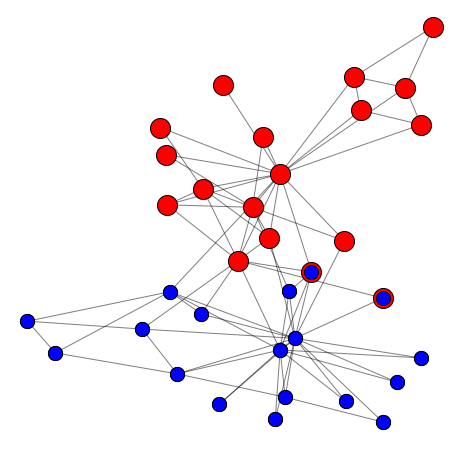

In [64]:
pos = nx.spring_layout(G, seed=0)
viz.plot_network_clusters(G, coms, pos, plot_overlaps=True)

In [65]:
com1 = set(coms.communities[0])
com2 = set(coms.communities[1])
overlap = com1 & com2
print(overlap)

{8, 9}


## LPANNI

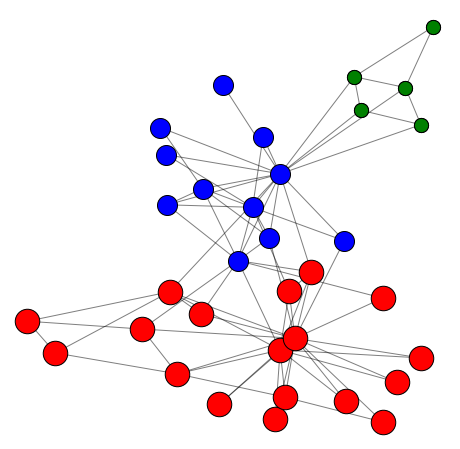

In [67]:
coms = algorithms.lpanni(G)
pos = nx.spring_layout(G, seed=0)
viz.plot_network_clusters(G, coms, pos, plot_overlaps=True)

## EnDNTM

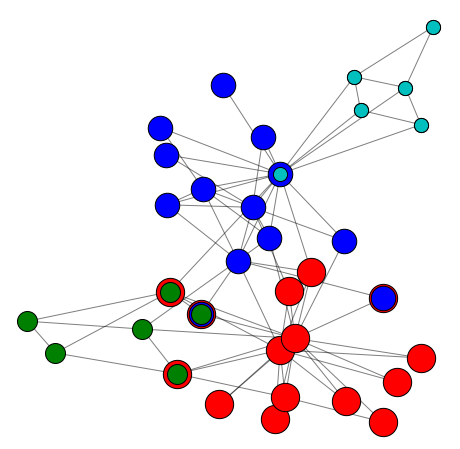

In [119]:
coms_l = [algorithms.louvain(G), algorithms.label_propagation(G), algorithms.walktrap(G)]
coms = algorithms.endntm(G, coms_l)
pos = nx.spring_layout(G, seed=0)
viz.plot_network_clusters(G, coms, pos, plot_overlaps=True)

## Core Expansion

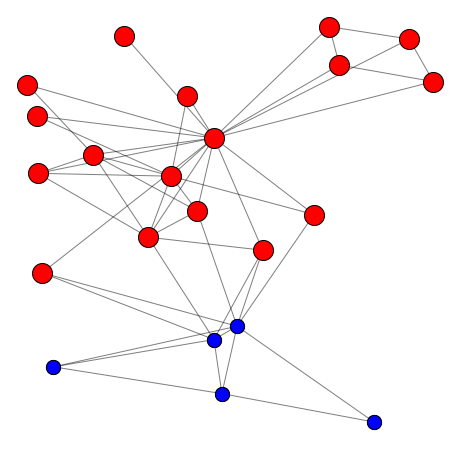

In [21]:
coms = algorithms.core_expansion(G)
pos = nx.spring_layout(G, seed=0)
viz.plot_network_clusters(G, coms, pos, plot_overlaps=True)

## BIG CLAM

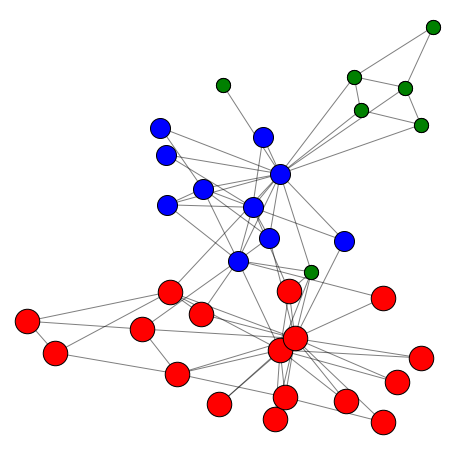

In [24]:
coms = algorithms.big_clam(G)
pos = nx.spring_layout(G, seed=0)
viz.plot_network_clusters(G, coms, pos, plot_overlaps=True)

## danmf

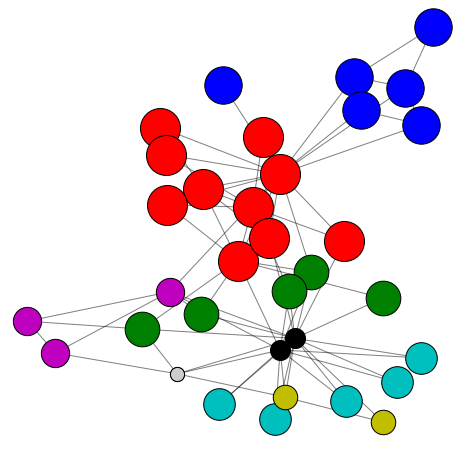

In [60]:
coms = algorithms.danmf(G)
pos = nx.spring_layout(G, seed=0)
viz.plot_network_clusters(G, coms, pos, plot_overlaps=True)

In [62]:
print(coms.communities)

[[0, 1, 2, 3, 7, 12, 13, 17, 19, 21], [4, 5, 6, 10, 11, 16], [8, 9, 27, 28, 30], [14, 15, 18, 20, 22], [24, 25, 31], [26, 29], [32, 33], [23]]


## BiMLPA

True


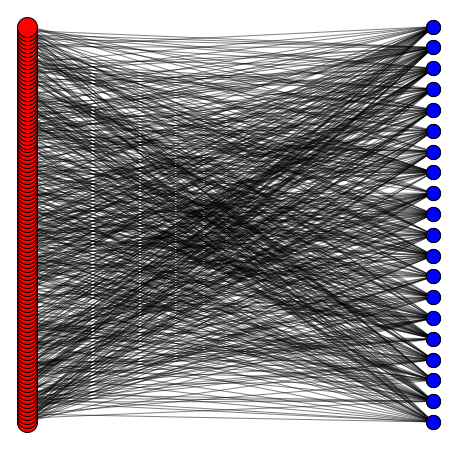

In [16]:
G = nx.algorithms.bipartite.generators.random_graph(100, 20, 0.3)
print(nx.is_connected(G))
coms = algorithms.bimlpa(G)
top = nx.bipartite.sets(G)[0]
pos = nx.bipartite_layout(G, top)
viz.plot_network_clusters(G, coms, pos, plot_overlaps=True)

In [37]:
from BiMLPA import *

G = nx.algorithms.bipartite.generators.random_graph(100, 20, 0.2)
G.nodes[0]
# print(nx.is_connected(G))

# # The parameters are set to theta=0.3, lambda=7
# bimlpa = BiMLPA_SqrtDeg(G, 0.3, 7)
# bimlpa.start()
# relabeling(G)
# top_coms, bottom_coms = output_community(G)

{'bipartite': 0}

In [18]:
top_coms

[[0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99]]